# Project Title : 
### Using Genetic-Algorithms for reducing the number of Features in classification dataset to predict the Target Label

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, algorithms
from scoop import futures
import random
import numpy
from scipy import interpolate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("All required libraries are present !")

All required libraries are present !


# Pre-processing

In [20]:
# Now to read in data from CSV file
# Download the dataset from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
# Put the CSV file in folder where there is '*.ipynb' file 

dfData = pd.read_csv('bank-additional-full.csv', sep=';')
print(dfData)

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  campaign  

In [21]:

# This step is general representation of all the features
# Now we have to encode the classification labels to numbers
# Get classes and one hot encoded feature vectors

r'''
Label Encoder and One Hot Encoder. These two encoders are parts of the SciKit Learn library in Python, and they are used to
convert categorical data, or text data, into numbers, which our predictive models can better understand.
'''

le = LabelEncoder()
le.fit(dfData['y'])
allClasses = le.transform(dfData['y'])

# allFeatures contains all the 20 column except the target column which contains 'Yes' or 'No'
allFeatures = dfData.drop(['y'], axis=1)



In [22]:
# Now in this step we form training, test, and validation datasets
# We split the data into 80% for training and 20% for validating

X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(allFeatures, allClasses, test_size=0.20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)


# Fitness Function

In [23]:
# Feature subset fitness function
# Function helps us to access the each individual from the population(hall of fame) according to the accuracy that it has achieved
# We calculate the accuracy using the Logistic Regression for each individual
# Logistic Regression is useful when target attributes are discrete in nature


def getFitness(individual, X_train, X_test, y_train, y_test):

    # Parse our feature columns that we don't use
    # Apply one hot encoding to the features
    cols = [index for index in range(len(individual)) if individual[index] == 0]
    X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
    X_trainOhFeatures = pd.get_dummies(X_trainParsed)
    X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
    X_testOhFeatures = pd.get_dummies(X_testParsed)

    # Remove any columns that aren't in both the training and test sets
    sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
    removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
    removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
    X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
    X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)

    # Apply logistic regression on the data, and calculate accuracy
    clf = LogisticRegression()
    clf.fit(X_trainOhFeatures, y_train)
    predictions = clf.predict(X_testOhFeatures)
    accuracy = accuracy_score(y_test, predictions)

    # Return calculated accuracy as fitness
    return (accuracy,)

# Setting Deap Global Parameters

In [24]:
# We use Deap Framework for Genetic Algorithm

#---------------DEAP GLOBAL VARIABLES (viewable by SCOOP)---------------

# Create Individuals
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(dfData.columns) - 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

#----------------------------------------------------------------------

# Hall of Fame (Population)

In [25]:
# Each generation has the number of individuals in the population.
# The function getHof() 'Get Hall of Fame' returns the list of individuals ordred by their fitness i.e. accuracy 
def getHof():

    # Initialize variables to use eaSimple
    numPop = 100
    numGen = 10
    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    # Launch genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

    # Return the hall of fame
    return hof

# Accuracy Matrix

In [26]:
# Now we write the function to get the accuracy on test data and accuracy on validation data
# Our function does this for all the individuals in the hof i.e. Hall of Fame

def getMetrics(hof):

    # Get list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]

    # Gather fitness data from each percentile
    testAccuracyList = []
    validationAccuracyList = []
    individualList = []
    for individual in hof:
        testAccuracy = individual.fitness.values
        validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
        testAccuracyList.append(testAccuracy[0])
        validationAccuracyList.append(validationAccuracy[0])
        individualList.append(individual)
    testAccuracyList.reverse()
    validationAccuracyList.reverse()
    return testAccuracyList, validationAccuracyList, individualList, percentileList

# Execution Starts

In [27]:
# Firstly , we will apply logistic regression using all the 20 features to acquire a baseline accuracy.

individual = [1 for i in range(len(allFeatures.columns))]
testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
print('Validation accuracy with all features: \t' + str(validationAccuracy[0]) + '\n')


Test accuracy with all features: 	0.9106221547799697
Validation accuracy with all features: 	0.9121145909201263



In [34]:

# Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.

hof = getHof()
testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)


gen	nevals	avg     	std       	min     	max     
0  	100   	0.903666	0.00720489	0.887405	0.913961
1  	69    	0.909628	0.00374662	0.894689	0.914264
2  	56    	0.911542	0.00197523	0.904401	0.914568
3  	68    	0.912338	0.00265148	0.899393	0.914871
4  	57    	0.912698	0.00234169	0.899241	0.914871
5  	65    	0.91297 	0.00254167	0.899393	0.914871
6  	46    	0.913083	0.00376105	0.887102	0.914871
7  	62    	0.913557	0.00198702	0.902276	0.91563 
8  	63    	0.913651	0.00238128	0.896662	0.91563 
9  	59    	0.914164	0.00147766	0.903338	0.91563 
10 	56    	0.914038	0.00255775	0.9     	0.91563 


In [43]:
# Now we get a list of subsets that performed best on validation data

maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

print('\n--------------------------------------------------Optimal Feature Subset(s)----------------------------------------------------\n')
for index in range(len(maxValAccSubsetIndicies)):
    print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
    print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
    print('Individual: \t' + str(maxValIndividuals[index]))
    print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
    print('Feature Subset: ' + str(maxValSubsets[index]))
    pass
print('\n-------------------------------------------------------------------------------------------------------------------------------\n')



--------------------------------------------------Optimal Feature Subset(s)----------------------------------------------------

Percentile: 			0.7939262472885033
Validation Accuracy: 		0.9134498664724447
Individual: 	[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0]
Number Features In Subset: 	10
Feature Subset: ['age', 'marital', 'education', 'housing', 'loan', 'day_of_week', 'duration', 'poutcome', 'emp.var.rate', 'euribor3m']

-------------------------------------------------------------------------------------------------------------------------------



# Data Visualization

In [36]:
'''
Now, we plot the test and validation classification accuracy to see how these numbers change as we move from our worst feature
subsets to the best feature subsets found by the genetic algorithm.
'''
# Calculate best fit line for validation classification accuracy (non-linear)
tck = interpolate.splrep(percentileList, validationAccuracyList, s=5.0)
ynew = interpolate.splev(percentileList, tck)

# Testing Data Scatter Plot

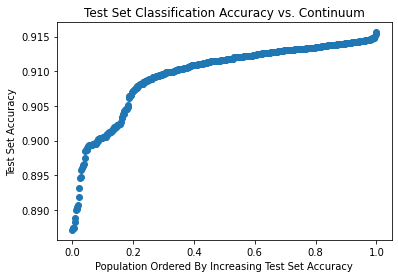

In [40]:
g = plt.figure(3)
plt.scatter(percentileList, testAccuracyList)
plt.title('Test Set Classification Accuracy vs. Continuum')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Test Set Accuracy')
g.show()

# Validation Data Scatter Plot

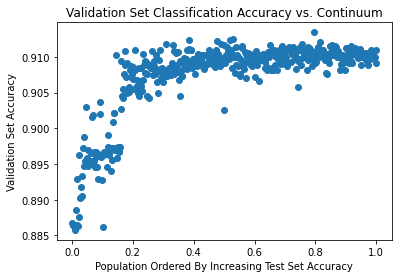

In [38]:
f = plt.figure(2)
plt.scatter(percentileList, validationAccuracyList)
plt.title('Validation Set Classification Accuracy vs. Continuum')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Validation Set Accuracy')
f.show()

# Validation Data Scatter Plot using Cubic-Spline Interpolation

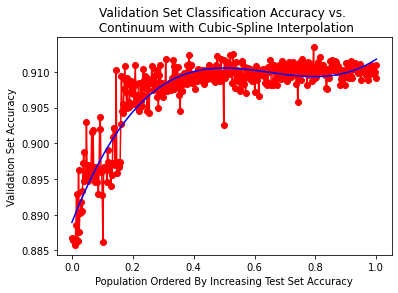

In [39]:
e = plt.figure(1)
plt.plot(percentileList, validationAccuracyList, marker='o', color='r')
plt.plot(percentileList, ynew, color='b')
plt.title('Validation Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Validation Set Accuracy')
e.show()

# Conclusion : 
### Using Genetic-Algorithms I have reduced the number of Required Features by ~50% to predict the Target Label. Genetic-Algorithm has successfully filtered  most prominent featues from dataset which are must to predict the Target Label